In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
import re
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectFpr
pd.set_option('display.max_columns',100)
import optuna
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]



In [2]:
df = pd.read_csv(r"C:\Users\Dell\Desktop\Samrat Fraud Project\creditcard.csv")

In [3]:
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  
0  149.62      0  
1    2.69      0  
2  378.66      0  
3  123.50      0  
4   69.99      0

### EDA

Text(0, 0.5, 'Frequency')

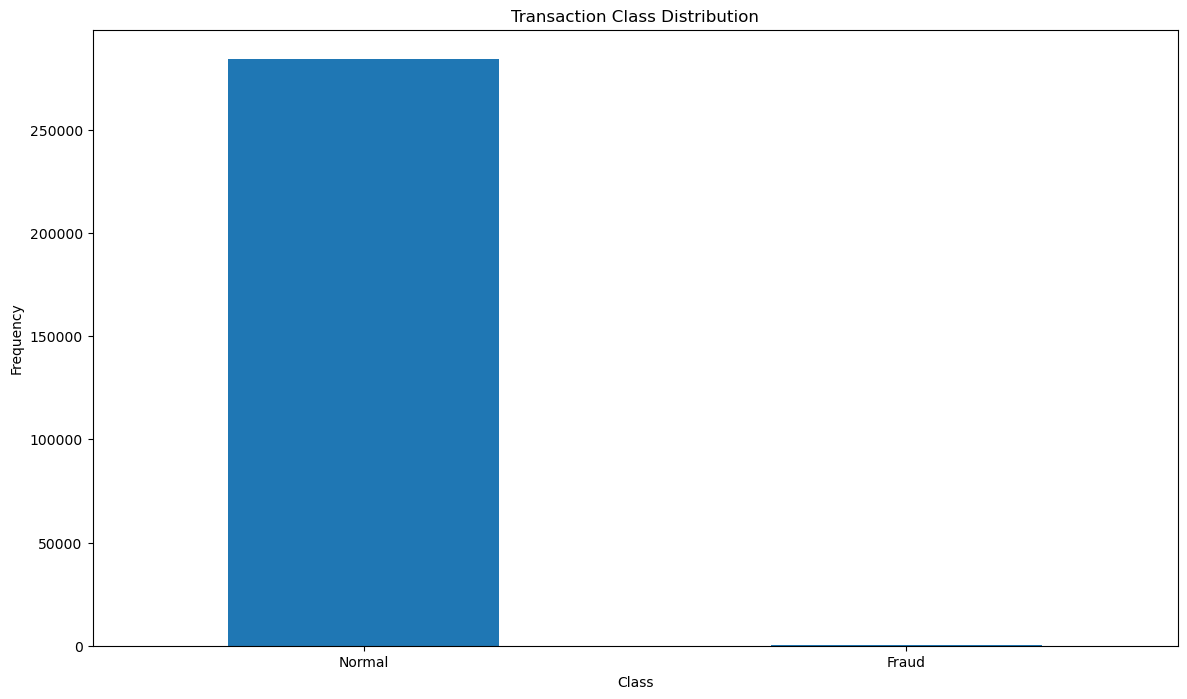

In [127]:

count_classes = pd.value_counts(df['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [105]:
## Get the Fraud and the normal dataset 

fraud = df[df['Class']==1]

normal = df[df['Class']==0]

In [106]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [107]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

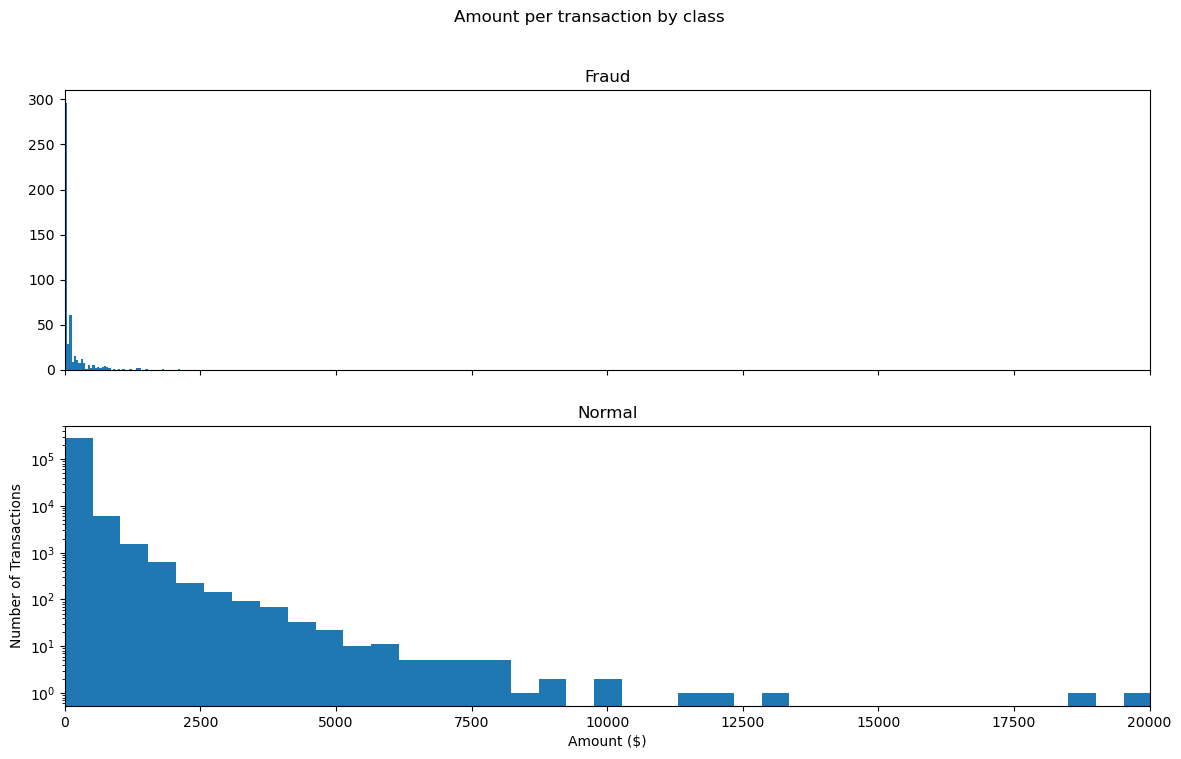

In [108]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();


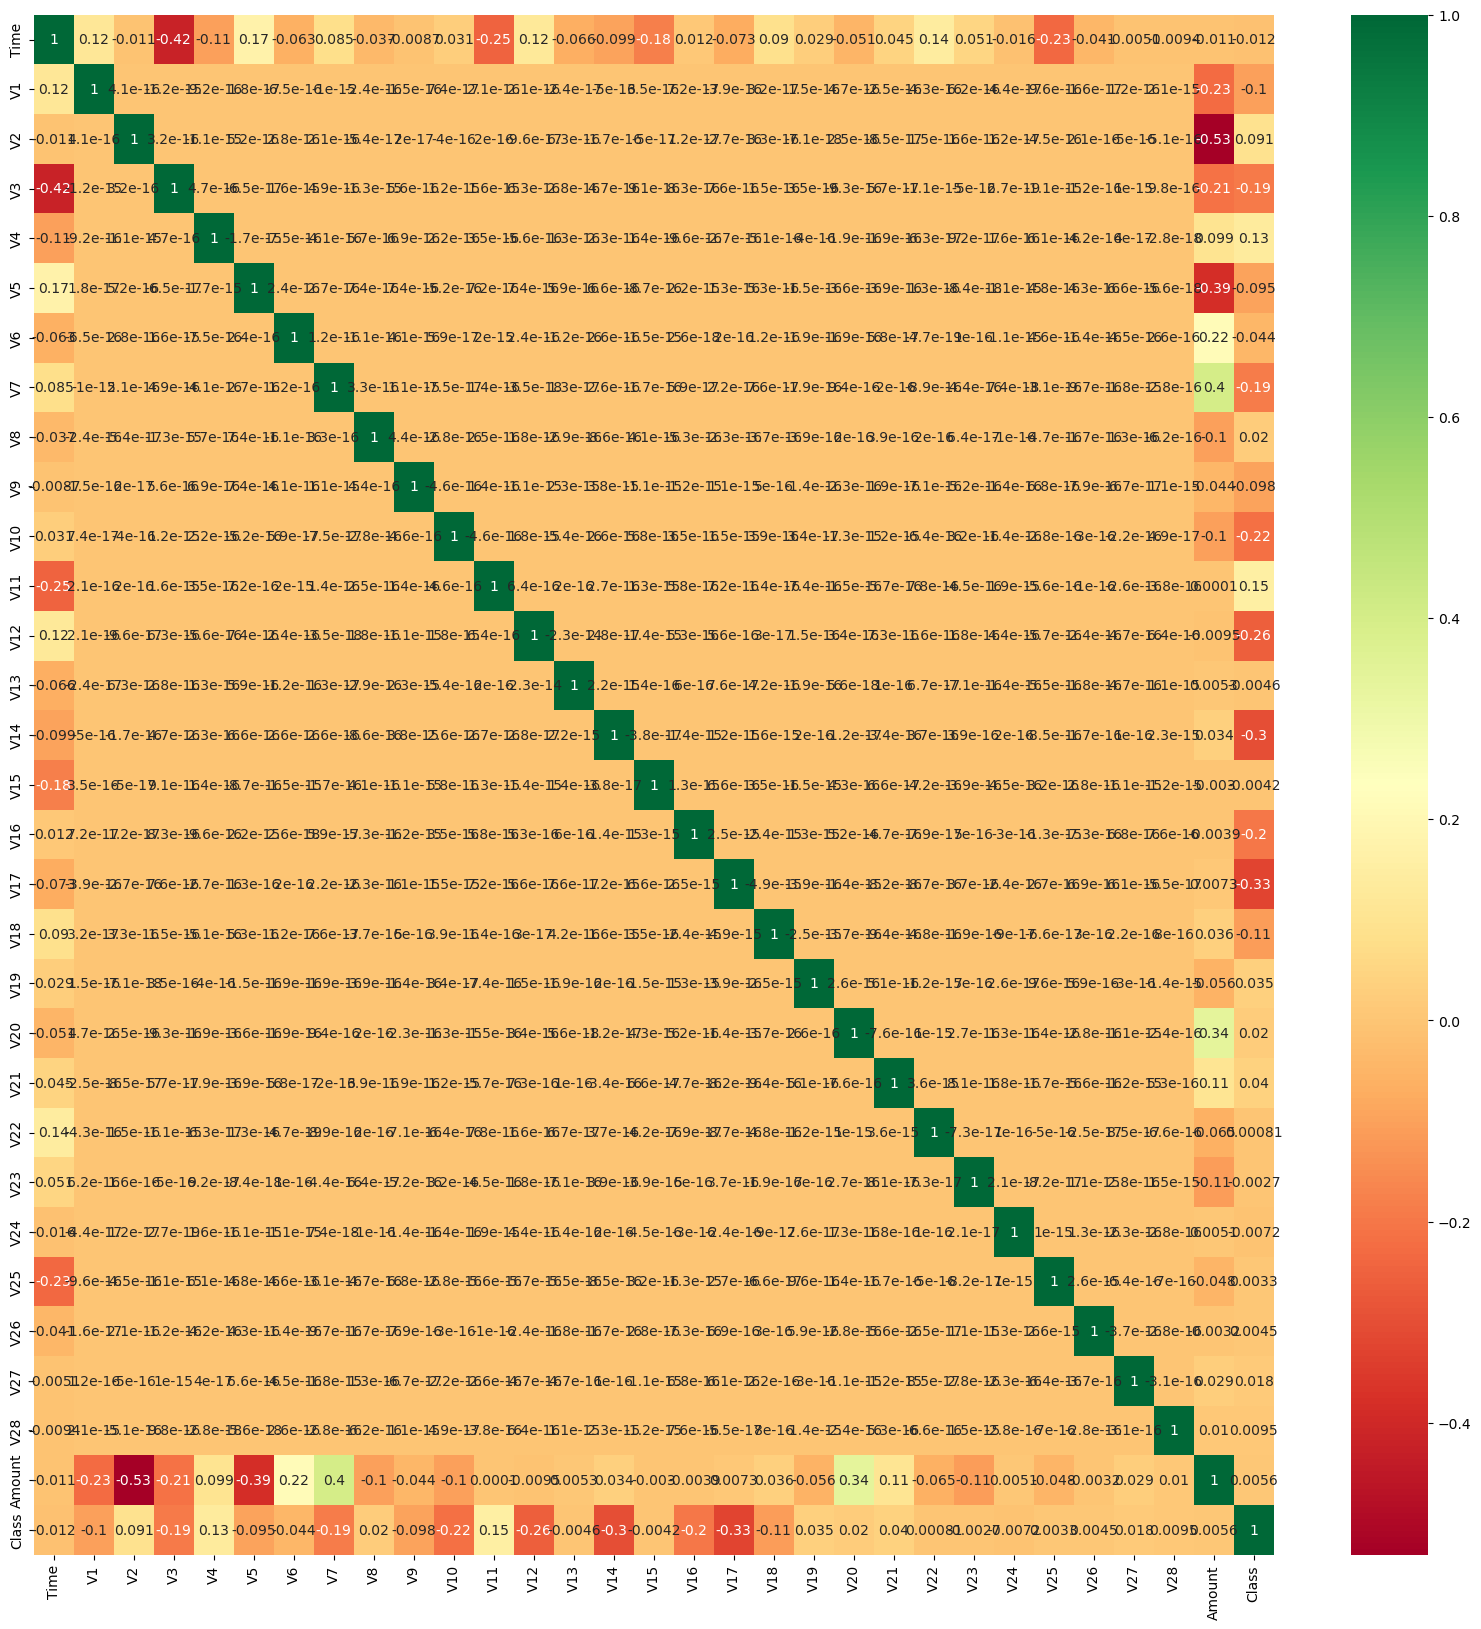

In [109]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

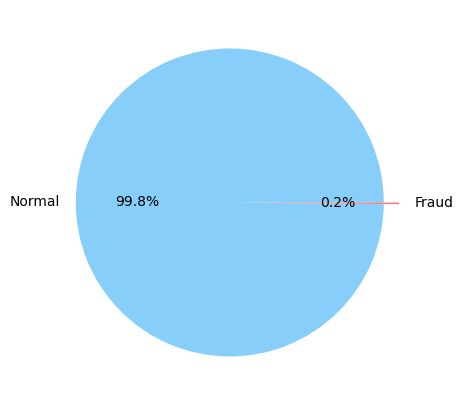

In [110]:
plt.figure(figsize=(5,5))
labels = ['Normal', 'Fraud']
sizes = [df['Class'].value_counts()[0], df['Class'].value_counts()[1]]
colors = ['lightskyblue','lightcoral']
explode = (0.05, 0.05)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, autopct='%.1f%%', colors=colors, data = df);

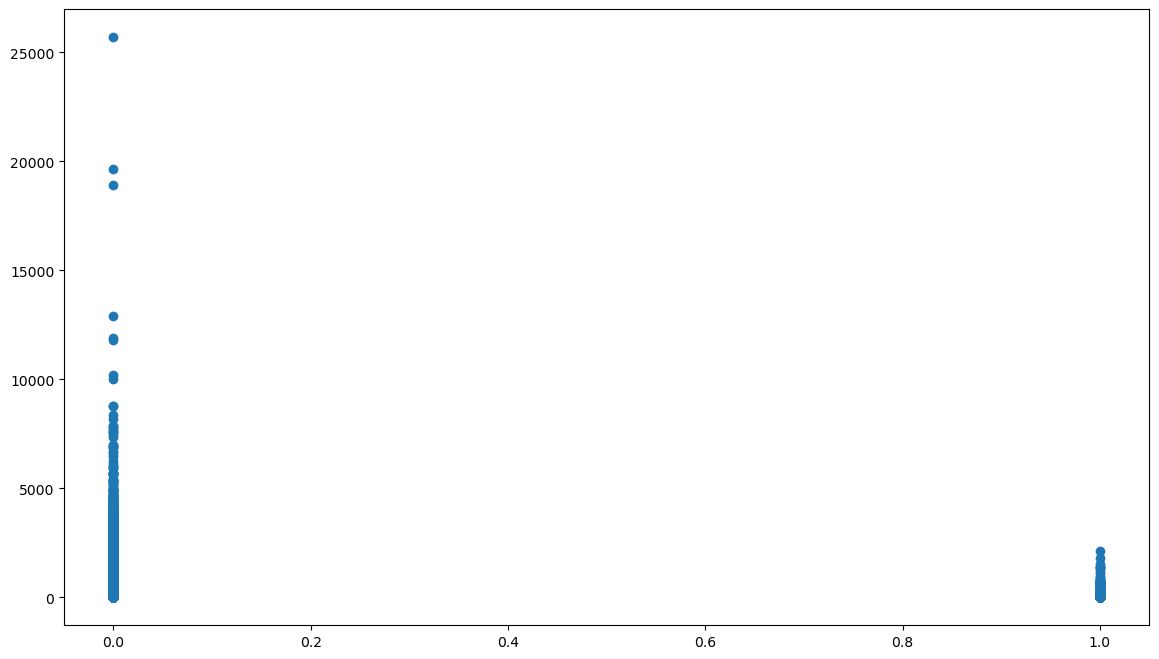

In [118]:
a = df['Class']
b = df['Amount']
plt.scatter(a, b)

<AxesSubplot:xlabel='Class', ylabel='Amount'>

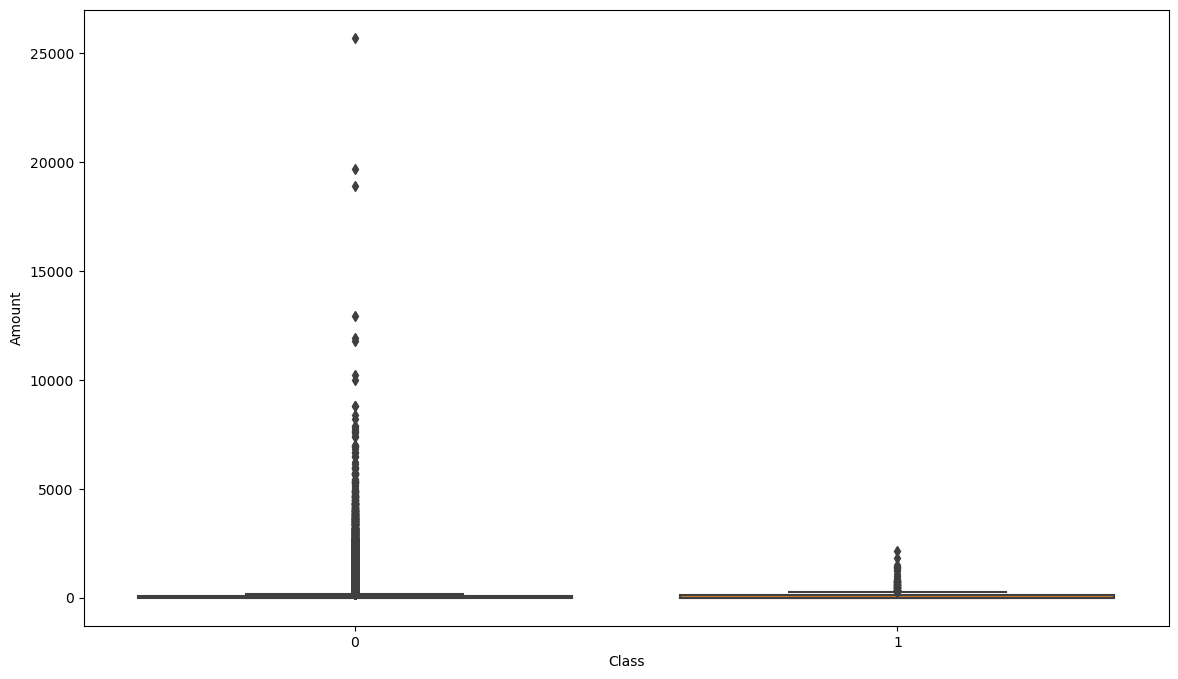

In [113]:
sns.boxplot(x='Class',y='Amount',data=df)

### Modelling


In [23]:
x,y = df.drop(['Class'],axis=1),df.Class

In [24]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1)

In [25]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train) 
x_test_scaled = scaler.transform(x_test)

In [26]:
w = {0:1, 1:99}
# define model
model = LogisticRegression(random_state=1, class_weight=w,max_iter=1000)
model.fit(x_train_scaled,y_train)

LogisticRegression(class_weight={0: 1, 1: 99}, max_iter=1000, random_state=1)

In [27]:
train_proba = model.predict_proba(x_train_scaled)[:,1]
train_proba

array([0.0049828 , 0.02703065, 0.04063183, ..., 0.16506998, 0.00288104,
       0.03536941])

In [28]:
test_proba = model.predict_proba(x_test_scaled)[:,1]
test_proba

array([0.01084883, 0.00481857, 0.00629462, ..., 0.01031757, 0.03148221,
       0.00120331])

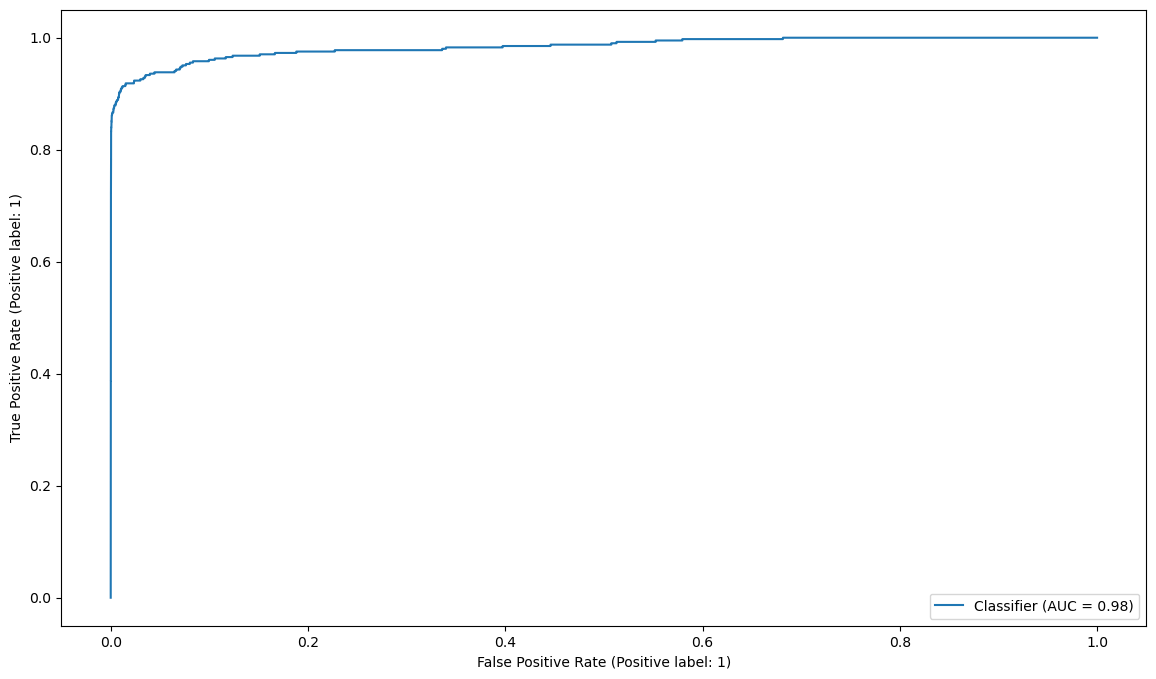

In [29]:
RocCurveDisplay.from_predictions(y_train,train_proba)

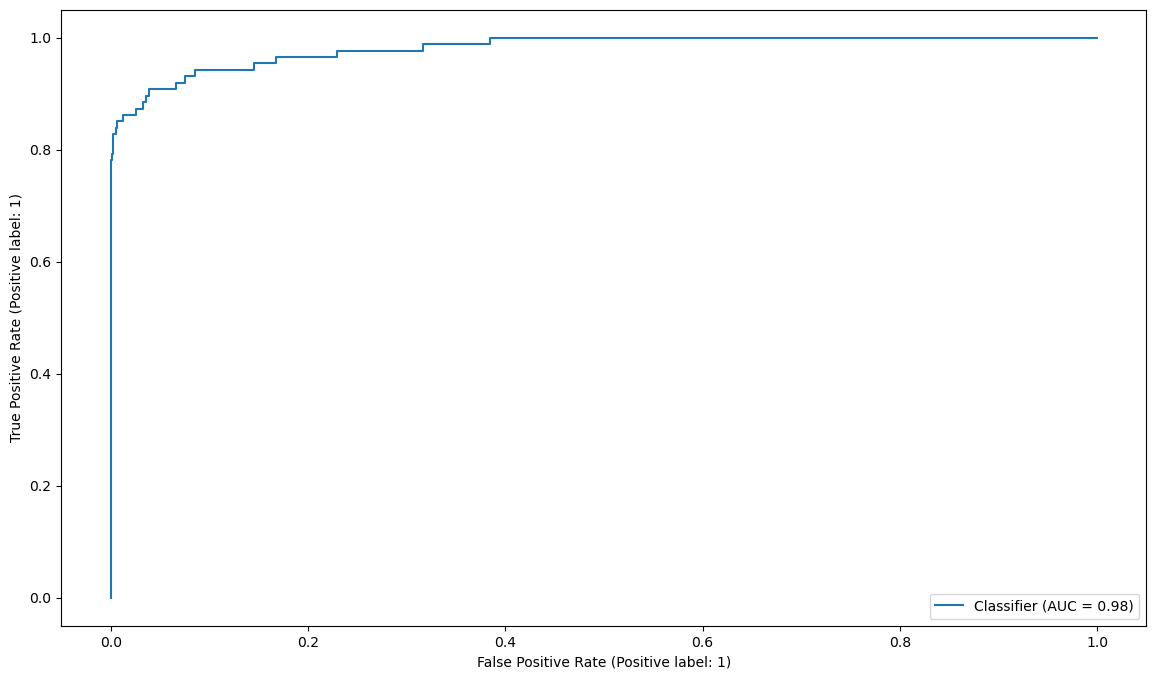

In [30]:
RocCurveDisplay.from_predictions(y_test,test_proba)

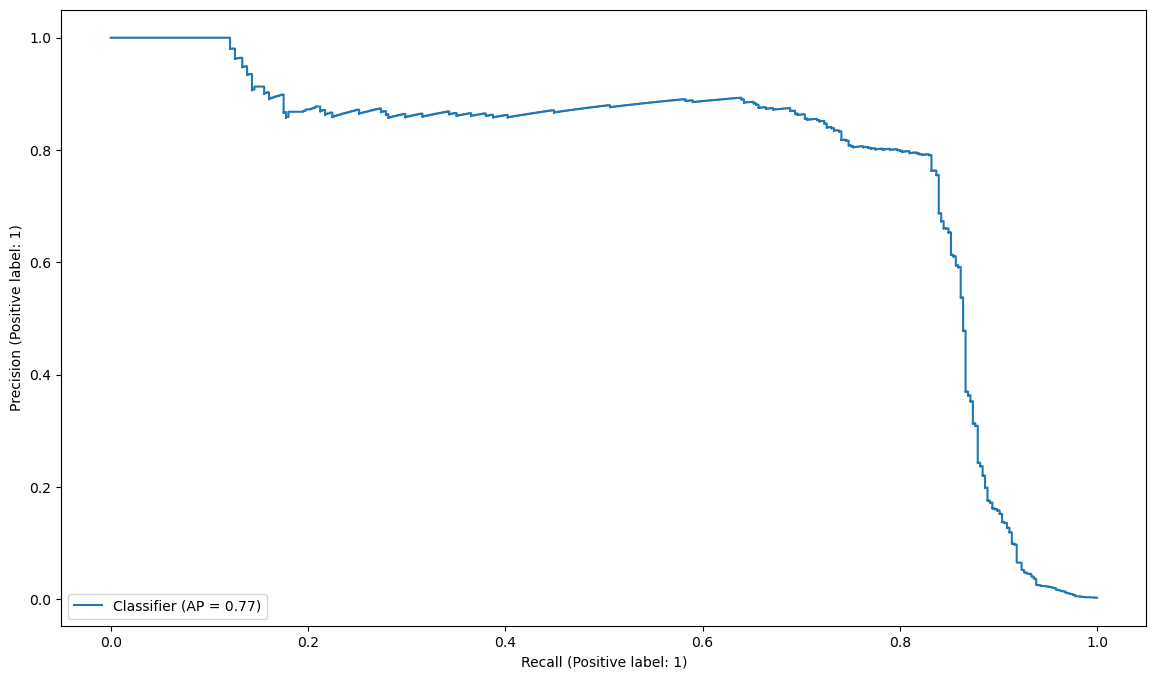

In [31]:
PrecisionRecallDisplay.from_predictions(y_train,train_proba)

In [32]:
y_train.value_counts()/len(y_train)

0    0.998222
1    0.001778
Name: Class, dtype: float64

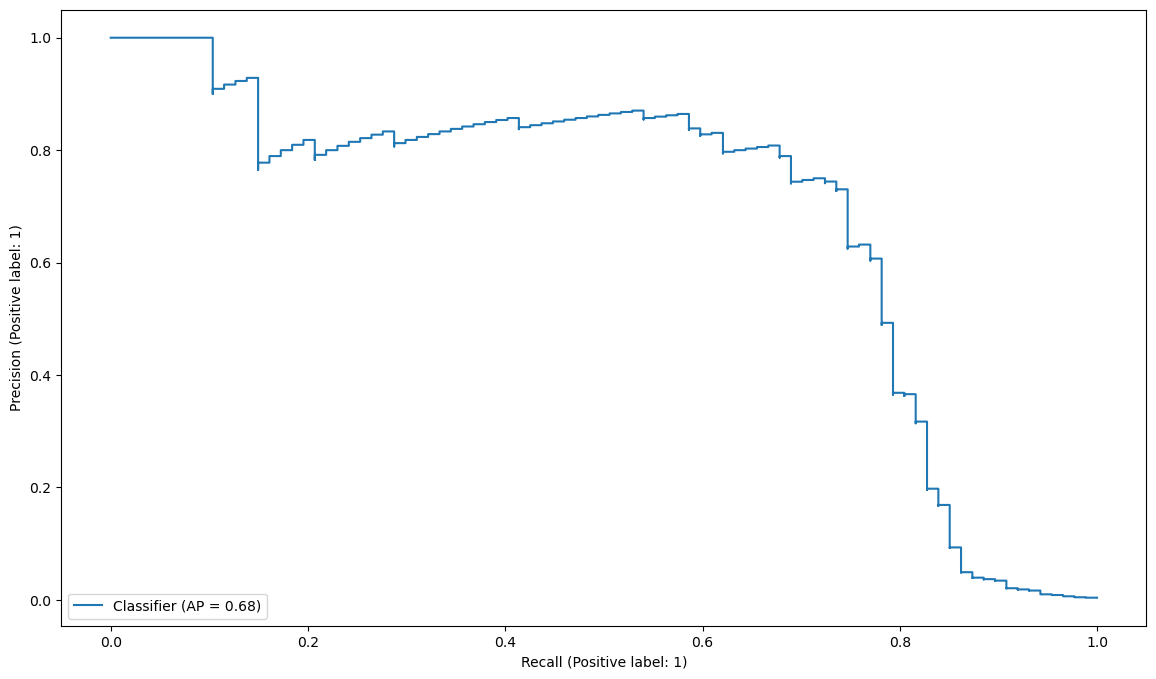

In [73]:
PrecisionRecallDisplay.from_predictions(y_test,test_proba)

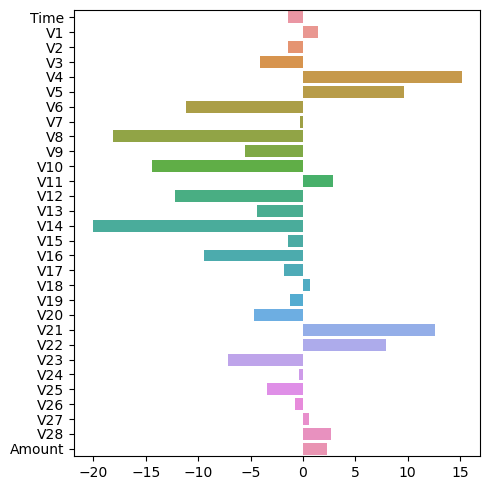

In [33]:
## Under Feature Importance
plt.figure(figsize=(5,5))
sns.barplot(y=x_train.columns,x=model.coef_[0])
plt.tight_layout()

In [34]:
### Feature Selection
feat_imp = pd.DataFrame(zip(x_train.columns,model.coef_[0]),columns = ['Feature','Importance'])
feat_imp.sort_values('Importance')

Feature  Importance
14     V14  -20.074334
8       V8  -18.100672
10     V10  -14.364975
12     V12  -12.242698
6       V6  -11.206664
16     V16   -9.461533
23     V23   -7.153366
9       V9   -5.538110
20     V20   -4.708512
13     V13   -4.421890
3       V3   -4.092403
25     V25   -3.390628
17     V17   -1.808428
2       V2   -1.474740
0     Time   -1.448491
15     V15   -1.428121
19     V19   -1.201169
26     V26   -0.799839
24     V24   -0.351543
7       V7   -0.308714
27     V27    0.618319
18     V18    0.696046
1       V1    1.452615
29  Amount    2.250535
28     V28    2.705484
11     V11    2.893925
22     V22    7.966644
5       V5    9.648218
21     V21   12.608595
4       V4   15.140105

In [35]:
p,r,th = precision_recall_curve(y_train,train_proba)

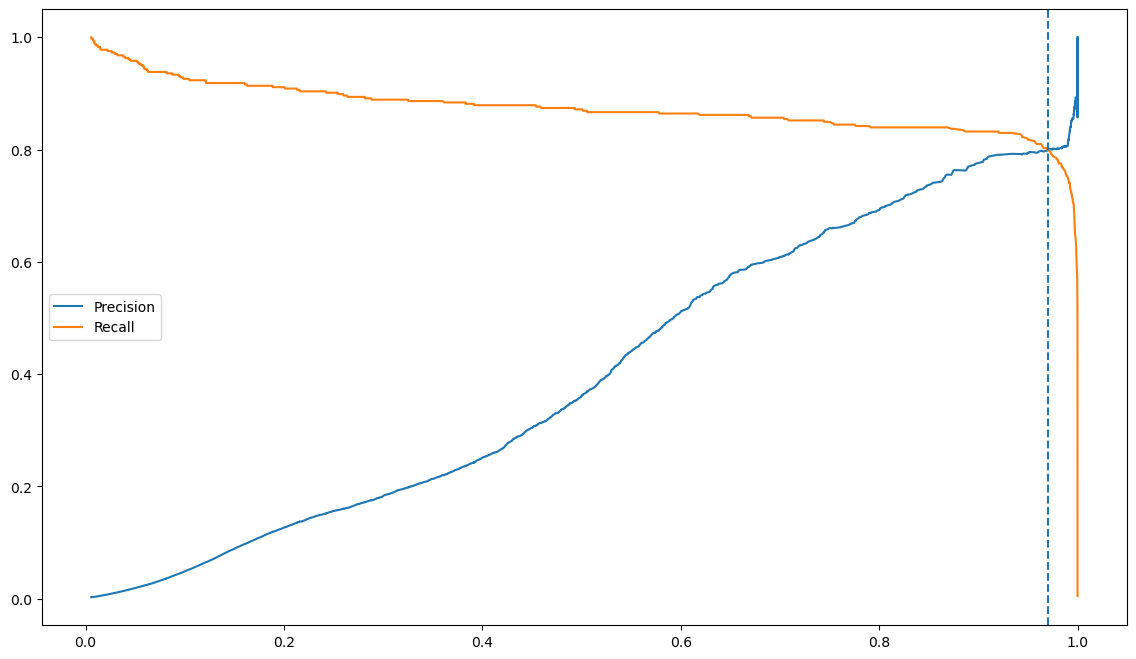

In [43]:
sns.lineplot(x=th,y=p[:-1],label='Precision')
sns.lineplot(x=th,y=r[:-1],label='Recall')
plt.axvline(0.97,linestyle='--')


In [44]:
thres = 0.97
train_pred = np.where(train_proba > thres,1,0)
test_pred= np.where(test_proba > thres,1,0)

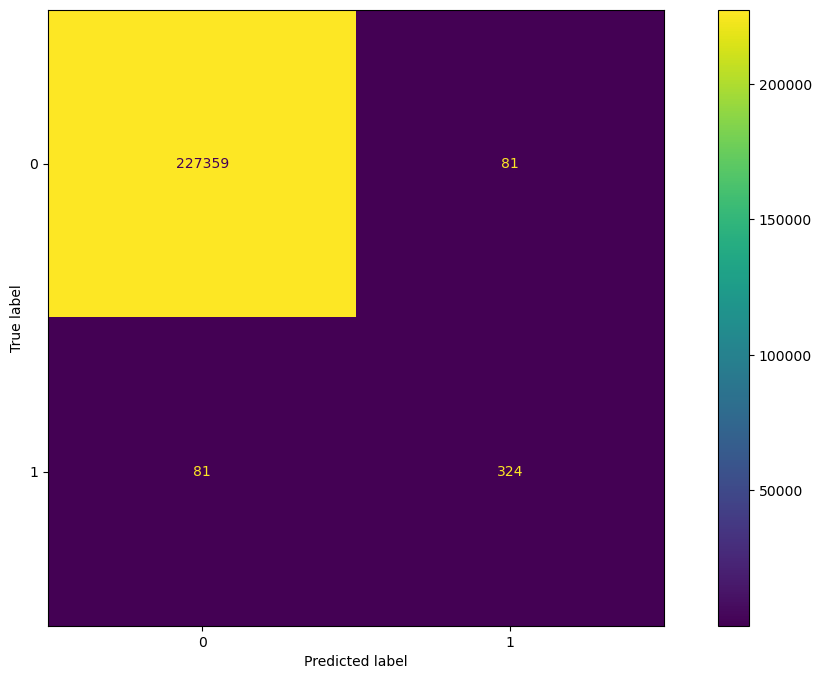

In [45]:
## Confusion Matrix

ConfusionMatrixDisplay.from_predictions(y_train,train_pred)

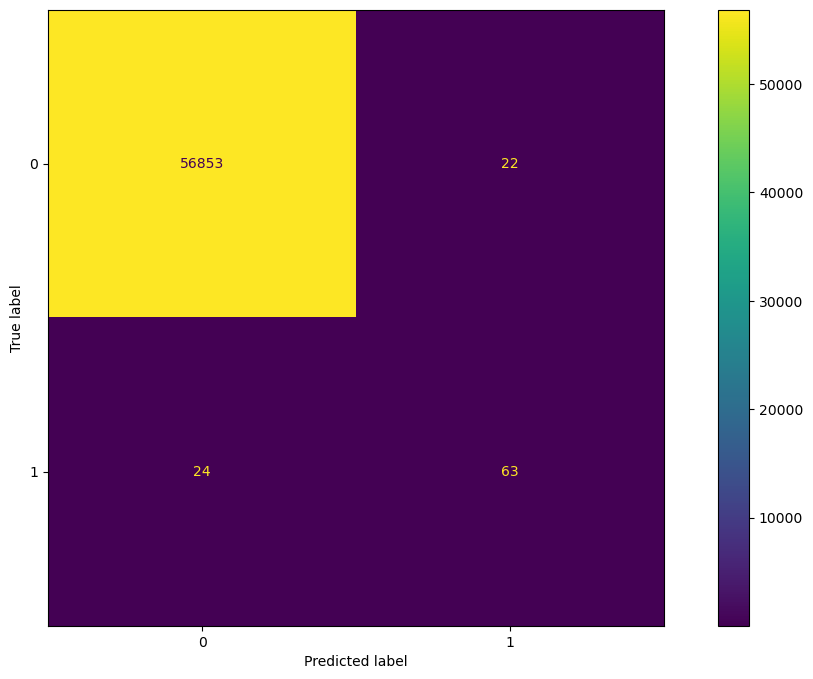

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test,test_pred)

In [47]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.74      0.72      0.73        87

    accuracy                           1.00     56962
   macro avg       0.87      0.86      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [48]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.80      0.80      0.80       405

    accuracy                           1.00    227845
   macro avg       0.90      0.90      0.90    227845
weighted avg       1.00      1.00      1.00    227845



<AxesSubplot:>

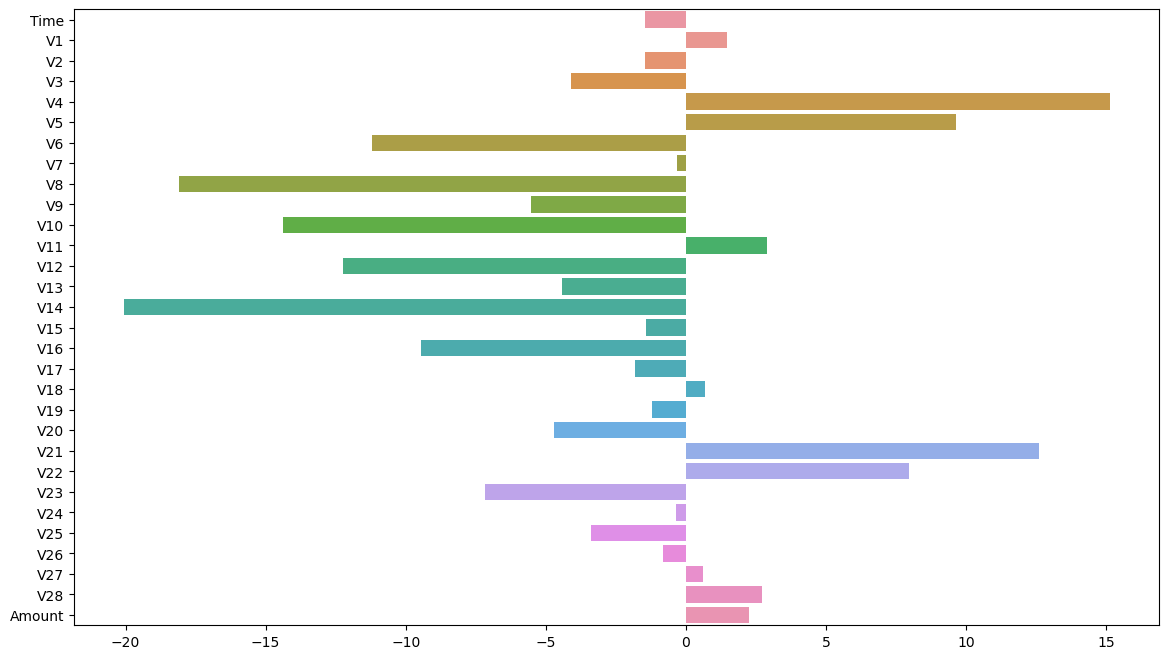

In [49]:
sns.barplot(x=model.coef_[0],y=x_train.columns)

In [62]:
weights = {0:492, 1:284315}

In [67]:
model = DecisionTreeClassifier(class_weight=weights)
model.fit(x_train_scaled,y_train)

DecisionTreeClassifier(class_weight={0: 492, 1: 284315})

In [64]:
train_pred = model.predict(x_train_scaled)
test_pred = model.predict(x_test_scaled)

In [74]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.74      0.76      0.75        87

    accuracy                           1.00     56962
   macro avg       0.87      0.88      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [69]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       1.00      1.00      1.00       405

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845



In [70]:
model.get_depth()

42

In [71]:
##parameter tuning of Decision Tree

params = {}
params["max_depth"] = list(range(1,42))
params["splitter"] = ["best","random"]
grid_reg= GridSearchCV(DecisionTreeClassifier(),param_grid=params,cv=5,scoring="neg_mean_squared_error")

In [72]:
grid_reg.fit(x_train_scaled,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [75]:
grid_reg.best_estimator_

DecisionTreeClassifier(max_depth=6)

In [76]:
model = grid_reg.best_estimator_

In [77]:
train_pred = model.predict(x_train_scaled)
test_pred = model.predict(x_test_scaled)

In [78]:
print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.98      0.84      0.90       405

    accuracy                           1.00    227845
   macro avg       0.99      0.92      0.95    227845
weighted avg       1.00      1.00      1.00    227845



In [79]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.89      0.74      0.81        87

    accuracy                           1.00     56962
   macro avg       0.94      0.87      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [80]:
## Random Forest

In [81]:
# 1. Define an objective function to be maximized.
def objective(trial):
    n_estimator = trial.suggest_int('n_estimator',1,1000)
    max_depth = trial.suggest_int('max_depth',1,10)
    criteria = trial.suggest_categorical('criteria',['gini','entropy'])
    
    model = RandomForestClassifier(n_estimators=n_estimator,max_depth=max_depth,criterion=criteria,
                                  class_weight=w)
    
    cvs = cross_val_score(model,x_train_scaled,y_train,cv=5,scoring='f1_macro')
    return np.mean(cvs)

In [83]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2023-03-17 19:32:06,751] A new study created in memory with name: no-name-3ccc22d1-3d3c-4ea1-9308-c91f64b92f58
[I 2023-03-17 19:33:25,484] Trial 0 finished with value: 0.9106465207989729 and parameters: {'n_estimator': 9, 'max_depth': 8, 'criteria': 'gini'}. Best is trial 0 with value: 0.9106465207989729.
[I 2023-03-17 20:09:29,831] Trial 1 finished with value: 0.9074238104436676 and parameters: {'n_estimator': 578, 'max_depth': 5, 'criteria': 'gini'}. Best is trial 0 with value: 0.9106465207989729.
[I 2023-03-17 20:11:24,837] Trial 2 finished with value: 0.9138693136195262 and parameters: {'n_estimator': 57, 'max_depth': 2, 'criteria': 'entropy'}. Best is trial 2 with value: 0.9138693136195262.
[I 2023-03-17 22:41:14,634] Trial 3 finished with value: 0.9077167600642069 and parameters: {'n_estimator': 865, 'max_depth': 5, 'criteria': 'gini'}. Best is trial 2 with value: 0.9138693136195262.
[I 2023-03-17 22:44:40,448] Trial 4 finished with value: 0.9129734527573297 and parameters: {'

In [84]:
study.best_params

{'n_estimator': 57, 'max_depth': 2, 'criteria': 'entropy'}

In [85]:
study.best_value

0.9138693136195262

In [86]:
optuna.visualization.plot_param_importances(study)

In [87]:
optuna.visualization.plot_optimization_history(study)

In [88]:
optuna.visualization.plot_parallel_coordinate(study)

In [89]:
study.best_params

{'n_estimator': 57, 'max_depth': 2, 'criteria': 'entropy'}

In [90]:
model = RandomForestClassifier(n_estimators=57,max_depth=2,criterion='entropy',class_weight=w)

In [91]:
model.fit(x_train_scaled,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 99}, criterion='entropy',
                       max_depth=2, n_estimators=57)

In [92]:
print(classification_report(y_train,model.predict(x_train_scaled)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227440
           1       0.82      0.83      0.83       405

    accuracy                           1.00    227845
   macro avg       0.91      0.92      0.91    227845
weighted avg       1.00      1.00      1.00    227845



In [102]:
print(classification_report(y_test,model.predict(x_test_scaled)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.93      0.78      0.85        87

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



<AxesSubplot:>

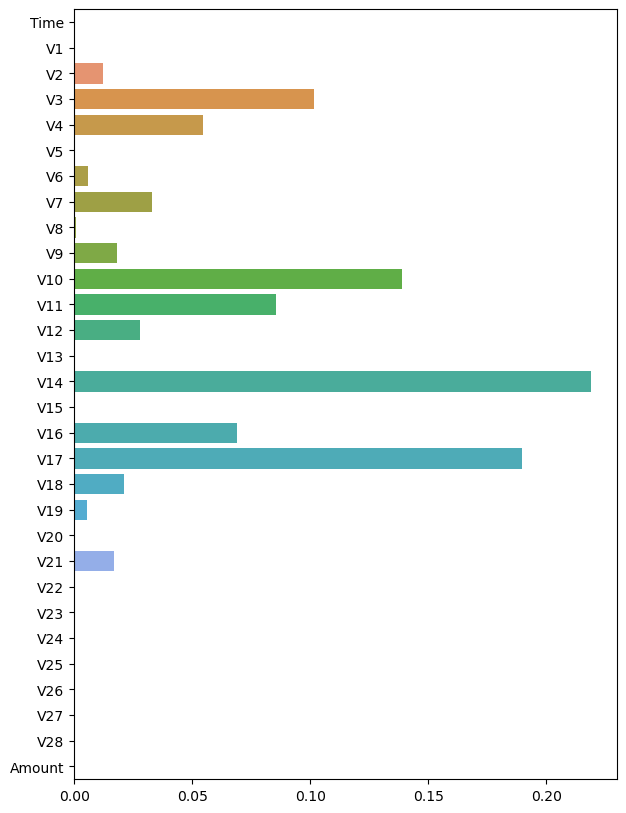

In [94]:
plt.figure(figsize=(7,10))
sns.barplot(x=model.feature_importances_,y=x_train.columns)